In [1]:
import os 
from pathlib import Path

# Get the notebook's directory
notebook_dir = Path.cwd()
print(f"Current directory: {notebook_dir}")

# Find project root (look for src directory as marker)
project_root = notebook_dir
while not (project_root / 'src').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if (project_root / 'src').exists():
    os.chdir(project_root)
    print(f"✓ Changed to project root: {project_root}")
else:
    print("⚠ Warning: Could not find project root, using current directory")

# Verify the files exist
results_path = Path('results/ablations/sampling/all_results.csv')
config_path = Path('configs/ablations/sampling_ablation.yaml')

print(f"\nFile checks:")
print(f"  Results CSV exists: {results_path.exists()}")
print(f"  Config YAML exists: {config_path.exists()}")

Current directory: /Users/katherinedemers/Documents/GitHub/diversity-mogfn/scripts/ablations
✓ Changed to project root: /Users/katherinedemers/Documents/GitHub/diversity-mogfn

File checks:
  Results CSV exists: True
  Config YAML exists: True


Create Grouped Bar Chart for Paper

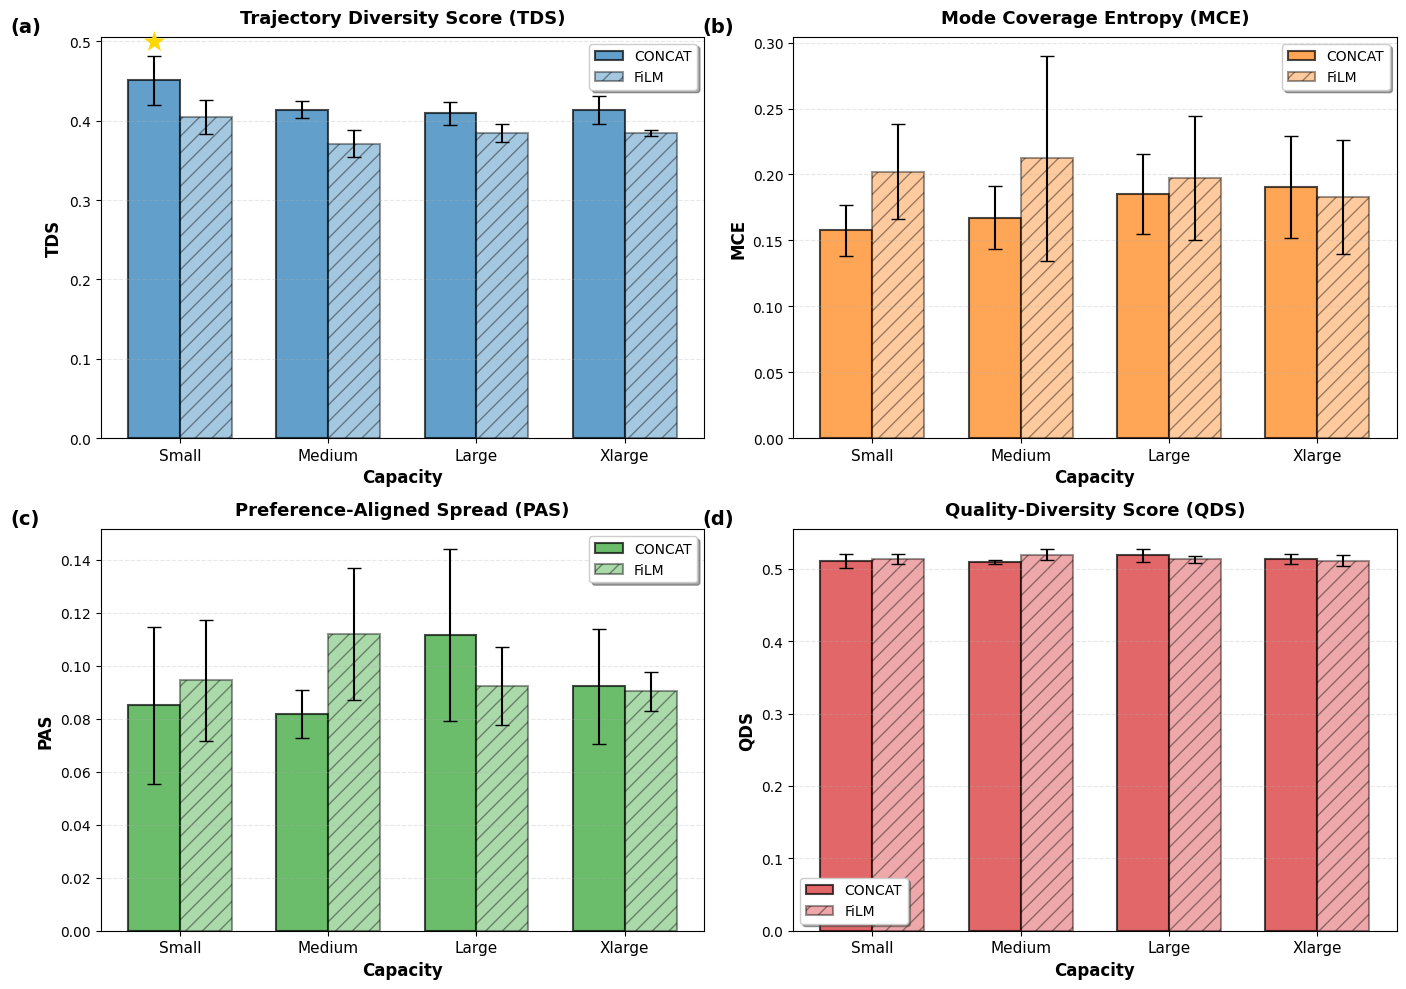

✓ Saved: conditioning_capacity_comparison.pdf
✓ Saved: conditioning_capacity_comparison.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load and prepare data
df = pd.read_csv('results/ablations/sampling/all_results.csv')
stats = df.groupby(['capacity', 'conditioning']).agg({
    'tds': ['mean', 'std'],
    'mce': ['mean', 'std'],
    'pas': ['mean', 'std'],
    'qds': ['mean', 'std']
}).reset_index()

# Flatten column names
stats.columns = ['_'.join(col).strip('_') for col in stats.columns.values]

# Define metrics and styling
metrics = [
    ('tds', 'Trajectory Diversity Score (TDS)', 'tab:blue'),
    ('mce', 'Mode Coverage Entropy (MCE)', 'tab:orange'),
    ('pas', 'Preference-Aligned Spread (PAS)', 'tab:green'),
    ('qds', 'Quality-Diversity Score (QDS)', 'tab:red')
]

sampling_order = ['temp_low', 'temp_medium', 'temp_high', 'temp_very_highx']
x = np.arange(len(sampling_order))
width = 0.35

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (metric, title, color) in enumerate(metrics):
    ax = axes[idx]
    
    # Extract data
    concat_means, concat_stds = [], []
    film_means, film_stds = [], []
    
    for cap in capacity_order:
        concat_row = stats[(stats['capacity'] == cap) & 
                          (stats['conditioning'] == 'concat')]
        film_row = stats[(stats['capacity'] == cap) & 
                        (stats['conditioning'] == 'film')]
        
        concat_means.append(concat_row[f'{metric}_mean'].values[0] 
                          if not concat_row.empty else 0)
        concat_stds.append(concat_row[f'{metric}_std'].values[0] 
                         if not concat_row.empty else 0)
        film_means.append(film_row[f'{metric}_mean'].values[0] 
                        if not film_row.empty else 0)
        film_stds.append(film_row[f'{metric}_std'].values[0] 
                       if not film_row.empty else 0)
    
    # Plot grouped bars
    bars1 = ax.bar(x - width/2, concat_means, width, 
                   yerr=concat_stds, capsize=5,
                   label='CONCAT', color=color, alpha=0.7,
                   edgecolor='black', linewidth=1.5)
    
    bars2 = ax.bar(x + width/2, film_means, width, 
                   yerr=film_stds, capsize=5,
                   label='FiLM', color=color, alpha=0.4,
                   edgecolor='black', linewidth=1.5, hatch='//')
    
    # Highlight the best bar
    best_concat = max(concat_means)
    best_film = max(film_means)
    
    if best_concat > best_film:
        # Add star to best CONCAT bar
        best_idx = concat_means.index(best_concat)
        ax.text(x[best_idx] - width/2, concat_means[best_idx] + concat_stds[best_idx], 
                '★', ha='center', va='bottom', fontsize=20, color='gold')
    
    # Formatting
    ax.set_xlabel('Sampling', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.upper(), fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels([c.capitalize() for c in capacity_order], 
                    fontsize=11)
    ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add panel label
    ax.text(-0.15, 1.05, f'({chr(97+idx)})', transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('results/ablations/sampling/report/sampling_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('results/ablations/sampling/report/sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: conditioning_capacity_comparison.pdf")
print("✓ Saved: conditioning_capacity_comparison.png")

HeatMap Figure (Appendix)

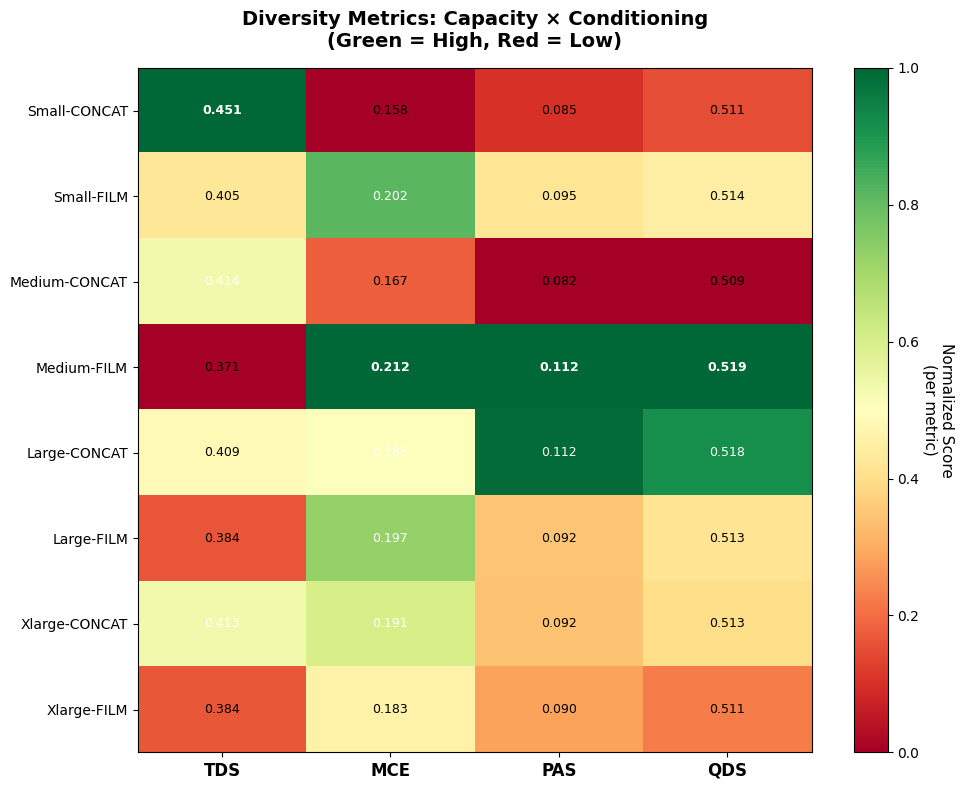

✓ Saved: results/ablations/capacity/report/conditioning_capacity_heatmap.pdf


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare heatmap data
heatmap_data = []
row_labels = []

for cap in capacity_order:
    for cond in ['concat', 'film']:
        row = stats[(stats['capacity'] == cap) & 
                   (stats['conditioning'] == cond)]
        if not row.empty:
            values = [
                row['tds_mean'].values[0],
                row['mce_mean'].values[0],
                row['pas_mean'].values[0],
                row['qds_mean'].values[0]
            ]
            heatmap_data.append(values)
            row_labels.append(f'{cap.capitalize()}-{cond.upper()}')

heatmap_array = np.array(heatmap_data)

# Normalize each column for color mapping
heatmap_normalized = np.zeros_like(heatmap_array)
for i in range(heatmap_array.shape[1]):
    col = heatmap_array[:, i]
    heatmap_normalized[:, i] = (col - col.min()) / (col.max() - col.min())

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_normalized, cmap='RdYlGn', aspect='auto', 
               vmin=0, vmax=1)

# Set labels
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['TDS', 'MCE', 'PAS', 'QDS'], 
                   fontsize=12, fontweight='bold')
ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels, fontsize=10)

# Add values as text
for i in range(len(row_labels)):
    for j in range(4):
        value = heatmap_array[i, j]
        norm_value = heatmap_normalized[i, j]
        text_color = 'white' if norm_value > 0.5 else 'black'
        
        # Highlight best value with bold
        is_best = value == heatmap_array[:, j].max()
        weight = 'bold' if is_best else 'normal'
        
        ax.text(j, i, f'{value:.3f}', 
               ha='center', va='center',
               color=text_color, fontsize=9, 
               fontweight=weight)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Score\n(per metric)', 
              rotation=270, labelpad=25, fontsize=11)

# Title
ax.set_title('Diversity Metrics: Capacity × Conditioning\n' +
            '(Green = High, Red = Low)', 
            fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('results/ablations/capacity/report/conditioning_capacity_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/ablations/capacity/report/conditioning_capacity_heatmap.pdf")

Radar chart (Presentation)

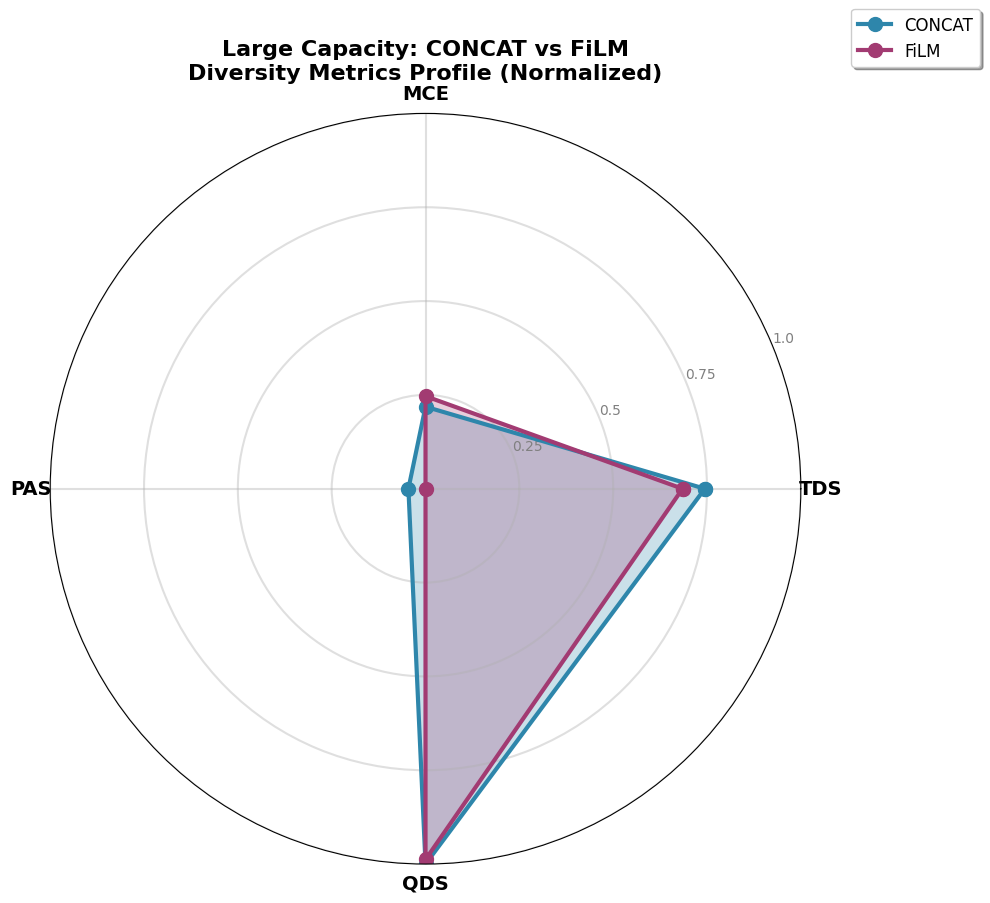

✓ Saved: results/ablations/capacity/report/large_capacity_radar.pdf


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Focus on large capacity (the winner)
large_data = stats[stats['capacity'] == 'large']

concat_row = large_data[large_data['conditioning'] == 'concat']
film_row = large_data[large_data['conditioning'] == 'film']

# Extract values
concat_values = [
    concat_row['tds_mean'].values[0],
    concat_row['mce_mean'].values[0],
    concat_row['pas_mean'].values[0],
    concat_row['qds_mean'].values[0]
]

film_values = [
    film_row['tds_mean'].values[0],
    film_row['mce_mean'].values[0],
    film_row['pas_mean'].values[0],
    film_row['qds_mean'].values[0]
]

# Normalize to [0, 1]
all_values = concat_values + film_values
min_val, max_val = min(all_values), max(all_values)

concat_norm = [(v - min_val) / (max_val - min_val) for v in concat_values]
film_norm = [(v - min_val) / (max_val - min_val) for v in film_values]

# Complete the circle
concat_norm += concat_norm[:1]
film_norm += film_norm[:1]

# Setup angles
metrics_labels = ['TDS', 'MCE', 'PAS', 'QDS']
angles = [n / len(metrics_labels) * 2 * pi 
          for n in range(len(metrics_labels))]
angles += angles[:1]

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot CONCAT
ax.plot(angles, concat_norm, 'o-', linewidth=3, 
        label='CONCAT', color='#2E86AB', markersize=10)
ax.fill(angles, concat_norm, alpha=0.25, color='#2E86AB')

# Plot FiLM
ax.plot(angles, film_norm, 'o-', linewidth=3, 
        label='FiLM', color='#A23B72', markersize=10)
ax.fill(angles, film_norm, alpha=0.25, color='#A23B72')

# Formatting
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_labels, fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], fontsize=10, color='gray')
ax.grid(True, linewidth=1.5, alpha=0.4)

# Title and legend
ax.set_title('Large Capacity: CONCAT vs FiLM\n' +
            'Diversity Metrics Profile (Normalized)', 
            fontsize=16, fontweight='bold', pad=25)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), 
         fontsize=12, frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('results/ablations/capacity/report/large_capacity_radar.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: results/ablations/capacity/report/large_capacity_radar.pdf")